# Climate Modelling Project - 2D Graphics

---------------

## 0. Import Libraries

In [36]:
import xarray as xr
import rioxarray
from datetime import datetime
from scipy.constants import g
import geopandas as gpd
import cartopy
from shapely.geometry import mapping
from visjobs.datas import get_ERA5
import requests
from bs4 import BeautifulSoup 
import matplotlib
import proplot
import cartopy
import matplotlib.pyplot as plt
from visualization_codes import plot_facet_map
import pandas as pd
from matplotlib.colors import BoundaryNorm
import numpy as np
from functions import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---------------

## 1. Open Data

#### **BELOW, YOU SHOULD CHECK THE PARAMETERS**

In [28]:
# Parameters to change ------------
is_single = False
model_var = 'T'   # possible for single: PMSL, RELHUM_2M, TOT_PREC, T_2M, U_10M, V_10M
                     # possible for pressure: FI, RELHUM, T
era5_var = 't' # possible for single: 2t, msl, 10u, 10v
                # possible for pressure: t, z
year = '2013'
model_level = 'pl' # sfc or pl
plevel = 50000 # in Pa (if using model_level=sfc, this must be 100000 (one hundred Pa))
start_month = 1
end_month = 12

# ----------------

path = r'Data/'
single = 'Merged_New_Single.nc'
pressure = 'Merged_New_Pressure.nc'

# model data
if is_single:

    dt = xr.open_dataset(path + single).sel(time = year)[model_var]

else:

    dt = xr.open_dataset(path + pressure).sel(time = year, pressure=plevel)[model_var]
    
# era5 data (remotely)
# var names
var_map_dict =  define_era5_var_matching_name()
# credentials
username, password = define_credentials()

# get data link
data_link = retrieve_era5_data_link(model_level, era5_var, year)

# start session
session = session_accredition(username, password)

#access authorization
store = xr.backends.PydapDataStore.open(data_link,
                                        session=session)
#get data
era5_dt = xr.open_dataset(store)

# clip to nearest borders
era5_dt = era5_dt.sel(longitude = slice(15, 40), 
                      latitude = slice(50, 30), 
                      level=plevel/100)[var_map_dict[era5_var]]

/mnt/c/Users/USER/JupyterLab/Portfolio/ClimateModelling/ClimateModellingLesson/functions.py:141: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 141 of the file /mnt/c/Users/USER/JupyterLab/Portfolio/ClimateModelling/ClimateModellingLesson/functions.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(page.content)


In [29]:
dt

<xarray.DataArray 'T' (time: 1460, rlat: 48, rlon: 62)>
[4344960 values with dtype=float32]
Coordinates:
    lat       (rlat, rlon) float32 ...
    lon       (rlat, rlon) float32 ...
    pressure  float32 5e+04
  * rlat      (rlat) float32 -3.16 -2.94 -2.72 -2.5 ... 6.52 6.74 6.96 7.18
  * rlon      (rlon) float32 -8.78 -8.56 -8.34 -8.12 -7.9 ... 3.98 4.2 4.42 4.64
  * time      (time) datetime64[ns] 2013-01-01 ... 2013-12-31T18:00:00
Attributes:
    standard_name:  air_temperature
    long_name:      temperature
    units:          K
    grid_mapping:   rotated_pole

---------------

## 2. Functions

In [4]:
# Retrieved functions from function.py in the current directory

-----------------------

## 3 Assign Projection Info to Datasets

### 3.1 Model Data

In [31]:
# General data information
crs_parameters = {'pole_longitude': -151.0,
                  'pole_latitude': 53.0,
                  }
crs_data = cartopy.crs.RotatedPole(**crs_parameters).proj4_params
x_dims = 'rlon'
y_dims = 'rlat'

# assign proj info
dt = assing_proj_info(dt, crs_data, x_dims, y_dims)

### 3.2 ERA5 Data

In [32]:
# General data information
crs_data_era5 = 4326
x_dims_era5 = 'longitude'
y_dims_era5 = 'latitude'

# assign proj info
era5_dt = assing_proj_info(era5_dt, crs_data_era5, x_dims_era5, y_dims_era5)

--------

## 4. Monthly Averages

### 4.1 Model Data

In [38]:
# get average of all months
average_model = get_average(dt, model_var, start_month,
                            end_month, 
                            )            
# get average of each month
average_bymonth_model = get_average_bymonth(dt, model_var, start_month, 
                                            end_month, 
                                            )                 

# assign proj info
average_model = assing_proj_info(average_model, crs_data, x_dims, y_dims)
average_bymonth_model = assing_proj_info(average_bymonth_model, crs_data, x_dims, y_dims)

### 4.2 ERA5 Data

In [39]:
average = get_average(era5_dt, var_map_dict[era5_var],
                      start_month, end_month,
                      )
average_bymonth = get_average_bymonth(era5_dt, var_map_dict[era5_var],
                                      start_month, end_month,
                                      )
    
# assign proj info
average = assing_proj_info(average, crs_data_era5, 
                           x_dims_era5, y_dims_era5)
average_bymonth = assing_proj_info(average_bymonth, crs_data_era5, 
                                   x_dims_era5, y_dims_era5)

---------------

## 5. Reproject ERA5 to Model Data

In [40]:
# average
average_reprojected = average.rio.reproject_match(average_model) \
                              .rename({'y':'rlat', 'x':'rlon', })
average_reprojected = average_reprojected.assign_coords(dict(
                            lon=(["rlat", "rlon"], average_model['lon'].values),
                            lat=(["rlat", "rlon"], average_model['lat'].values)))

# average by month
average_bymonth_reprojected = average_bymonth.rio.reproject_match(average_bymonth_model) \
                              .rename({'y':'rlat', 'x':'rlon', })
average_bymonth_reprojected = average_bymonth_reprojected.assign_coords(dict(
                                        lon=(["rlat", "rlon"], average_bymonth_model['lon'].values),
                                        lat=(["rlat", "rlon"], average_bymonth_model['lat'].values)))

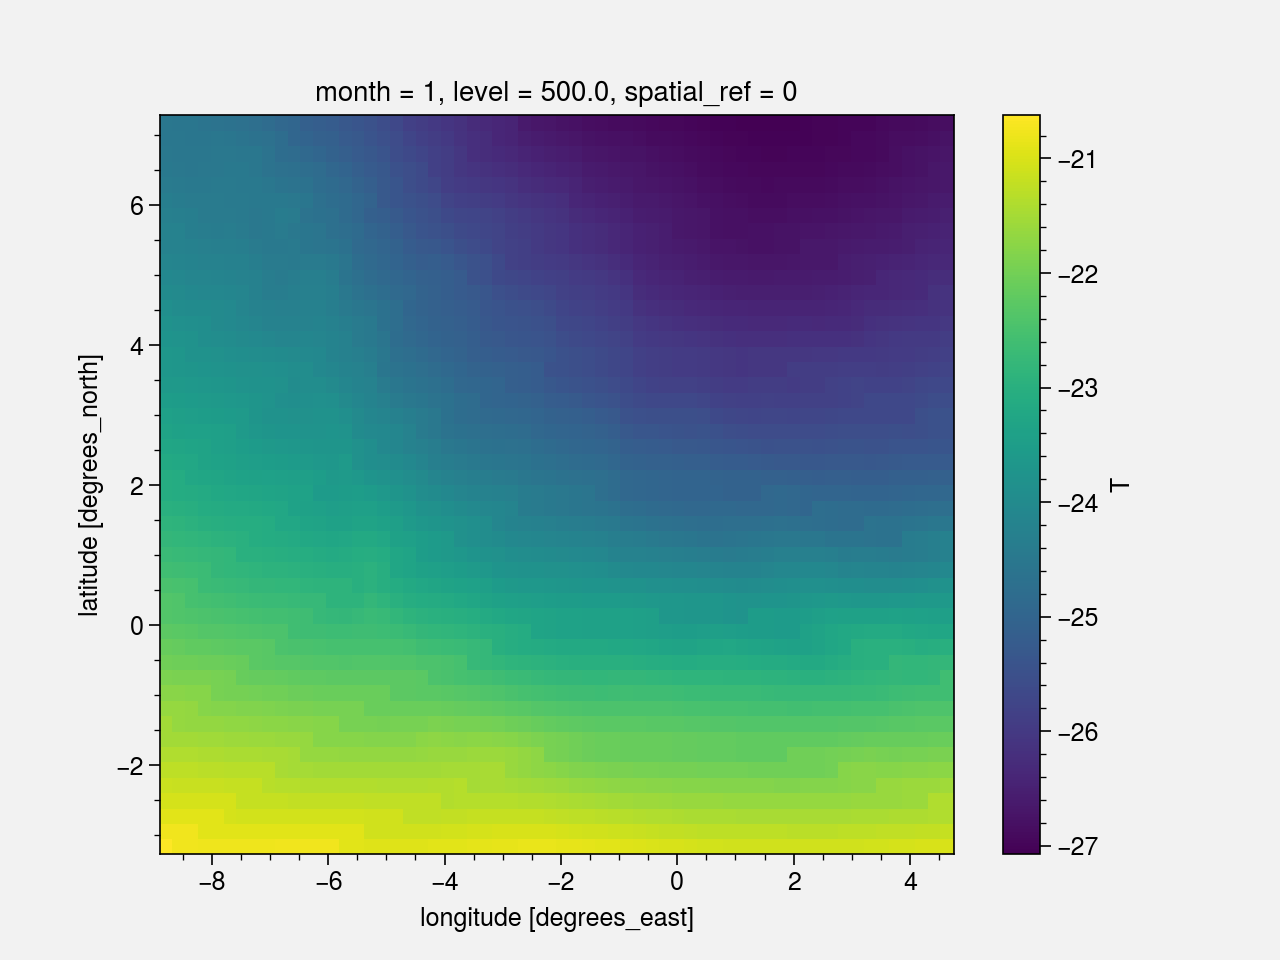

In [41]:
# ERA5 sample image
average_bymonth_reprojected[0].plot()

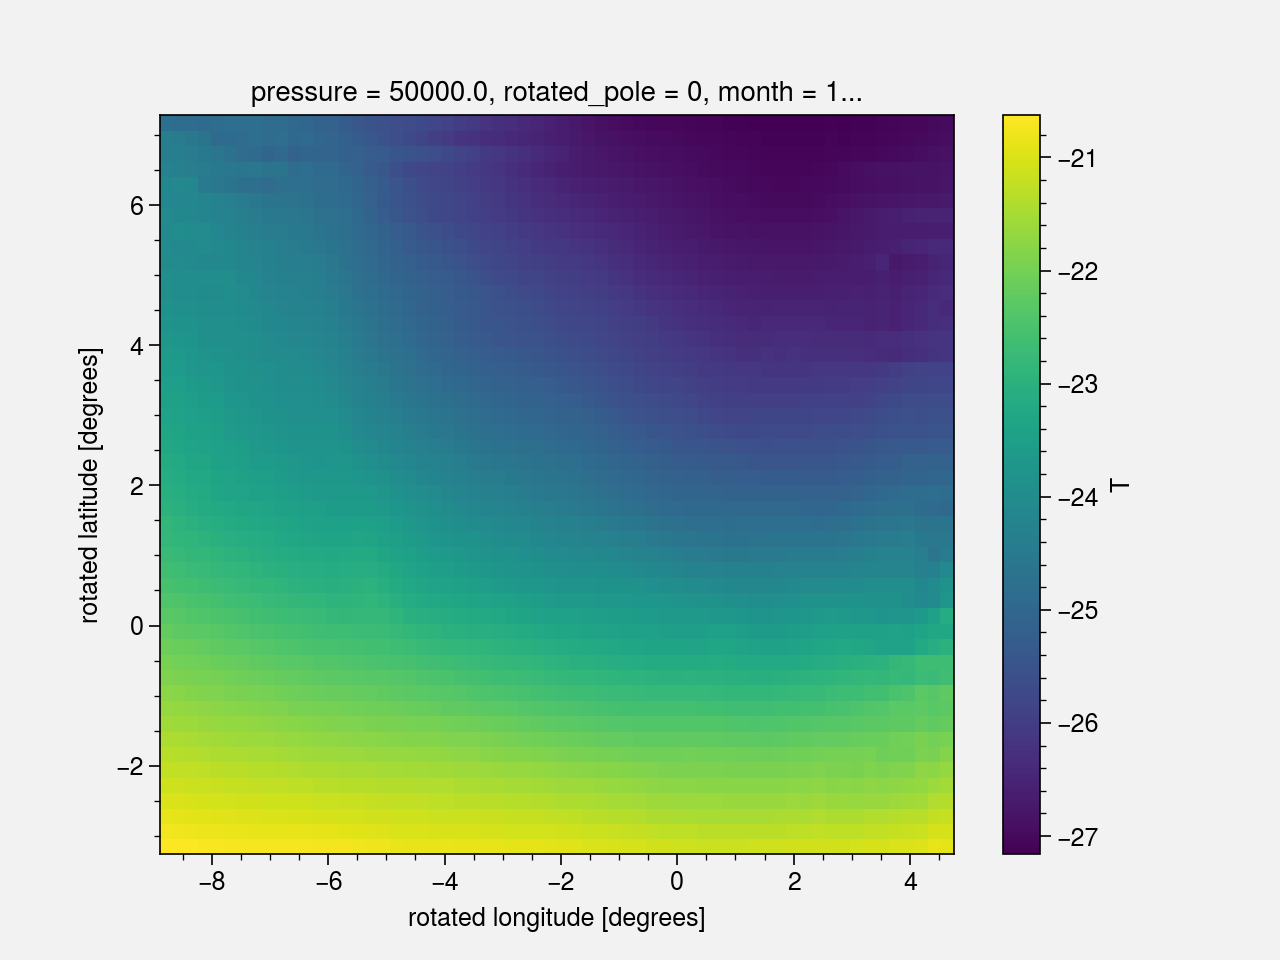

In [42]:
# MODEL sample image
average_bymonth_model[0].plot()

-------------

## 6. Visualization

### 6.1 Interpolate Datasets

In [43]:
rlat, rlon = average_model.indexes.values()

# interpolate whole months averages
average_reprojected_interp = average_reprojected.interp(rlon=rlon, rlat=rlat, method="nearest")
average_model_interp = average_model.interp(rlon=rlon, rlat=rlat, method="nearest")

# interpolate one monthly averages
average_bymonth_reprojected_interp = average_bymonth_reprojected.interp(rlon=rlon, rlat=rlat, method="nearest")
average_bymonth_model_interp = average_bymonth_model.interp(rlon=rlon, rlat=rlat, method="nearest")

### 6.2 Facet Graphic

In [44]:
average_difference = average_reprojected_interp - average_model_interp

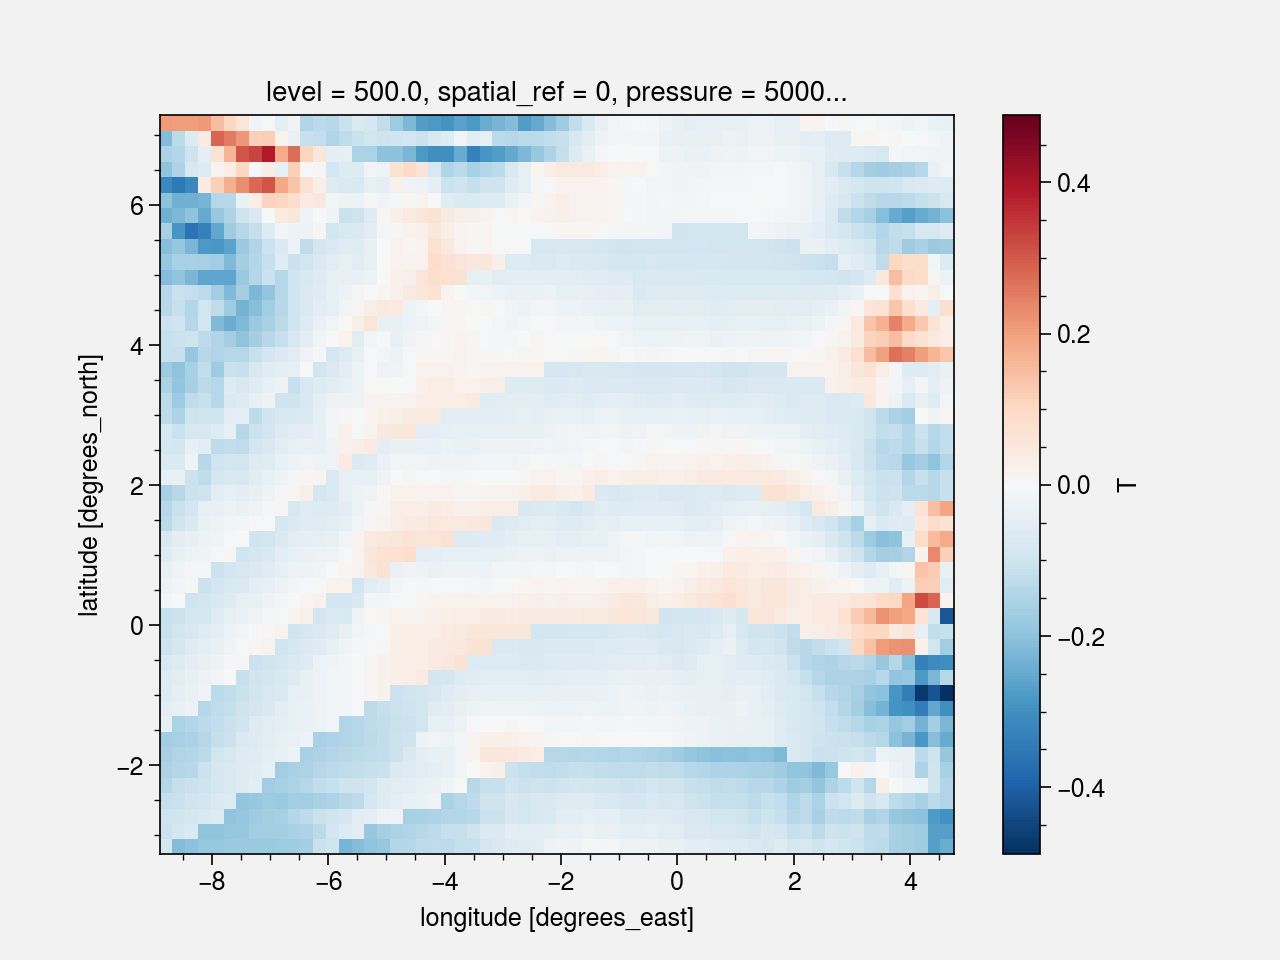

In [45]:
average_difference.plot()

### 6.2.1 Monhtly Mean Graphic

In [46]:
average_bymonth_difference = average_bymonth_reprojected_interp - average_bymonth_model_interp

#### **BELOW, YOU SHOULD CHECK THE PARAMETERS**

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)


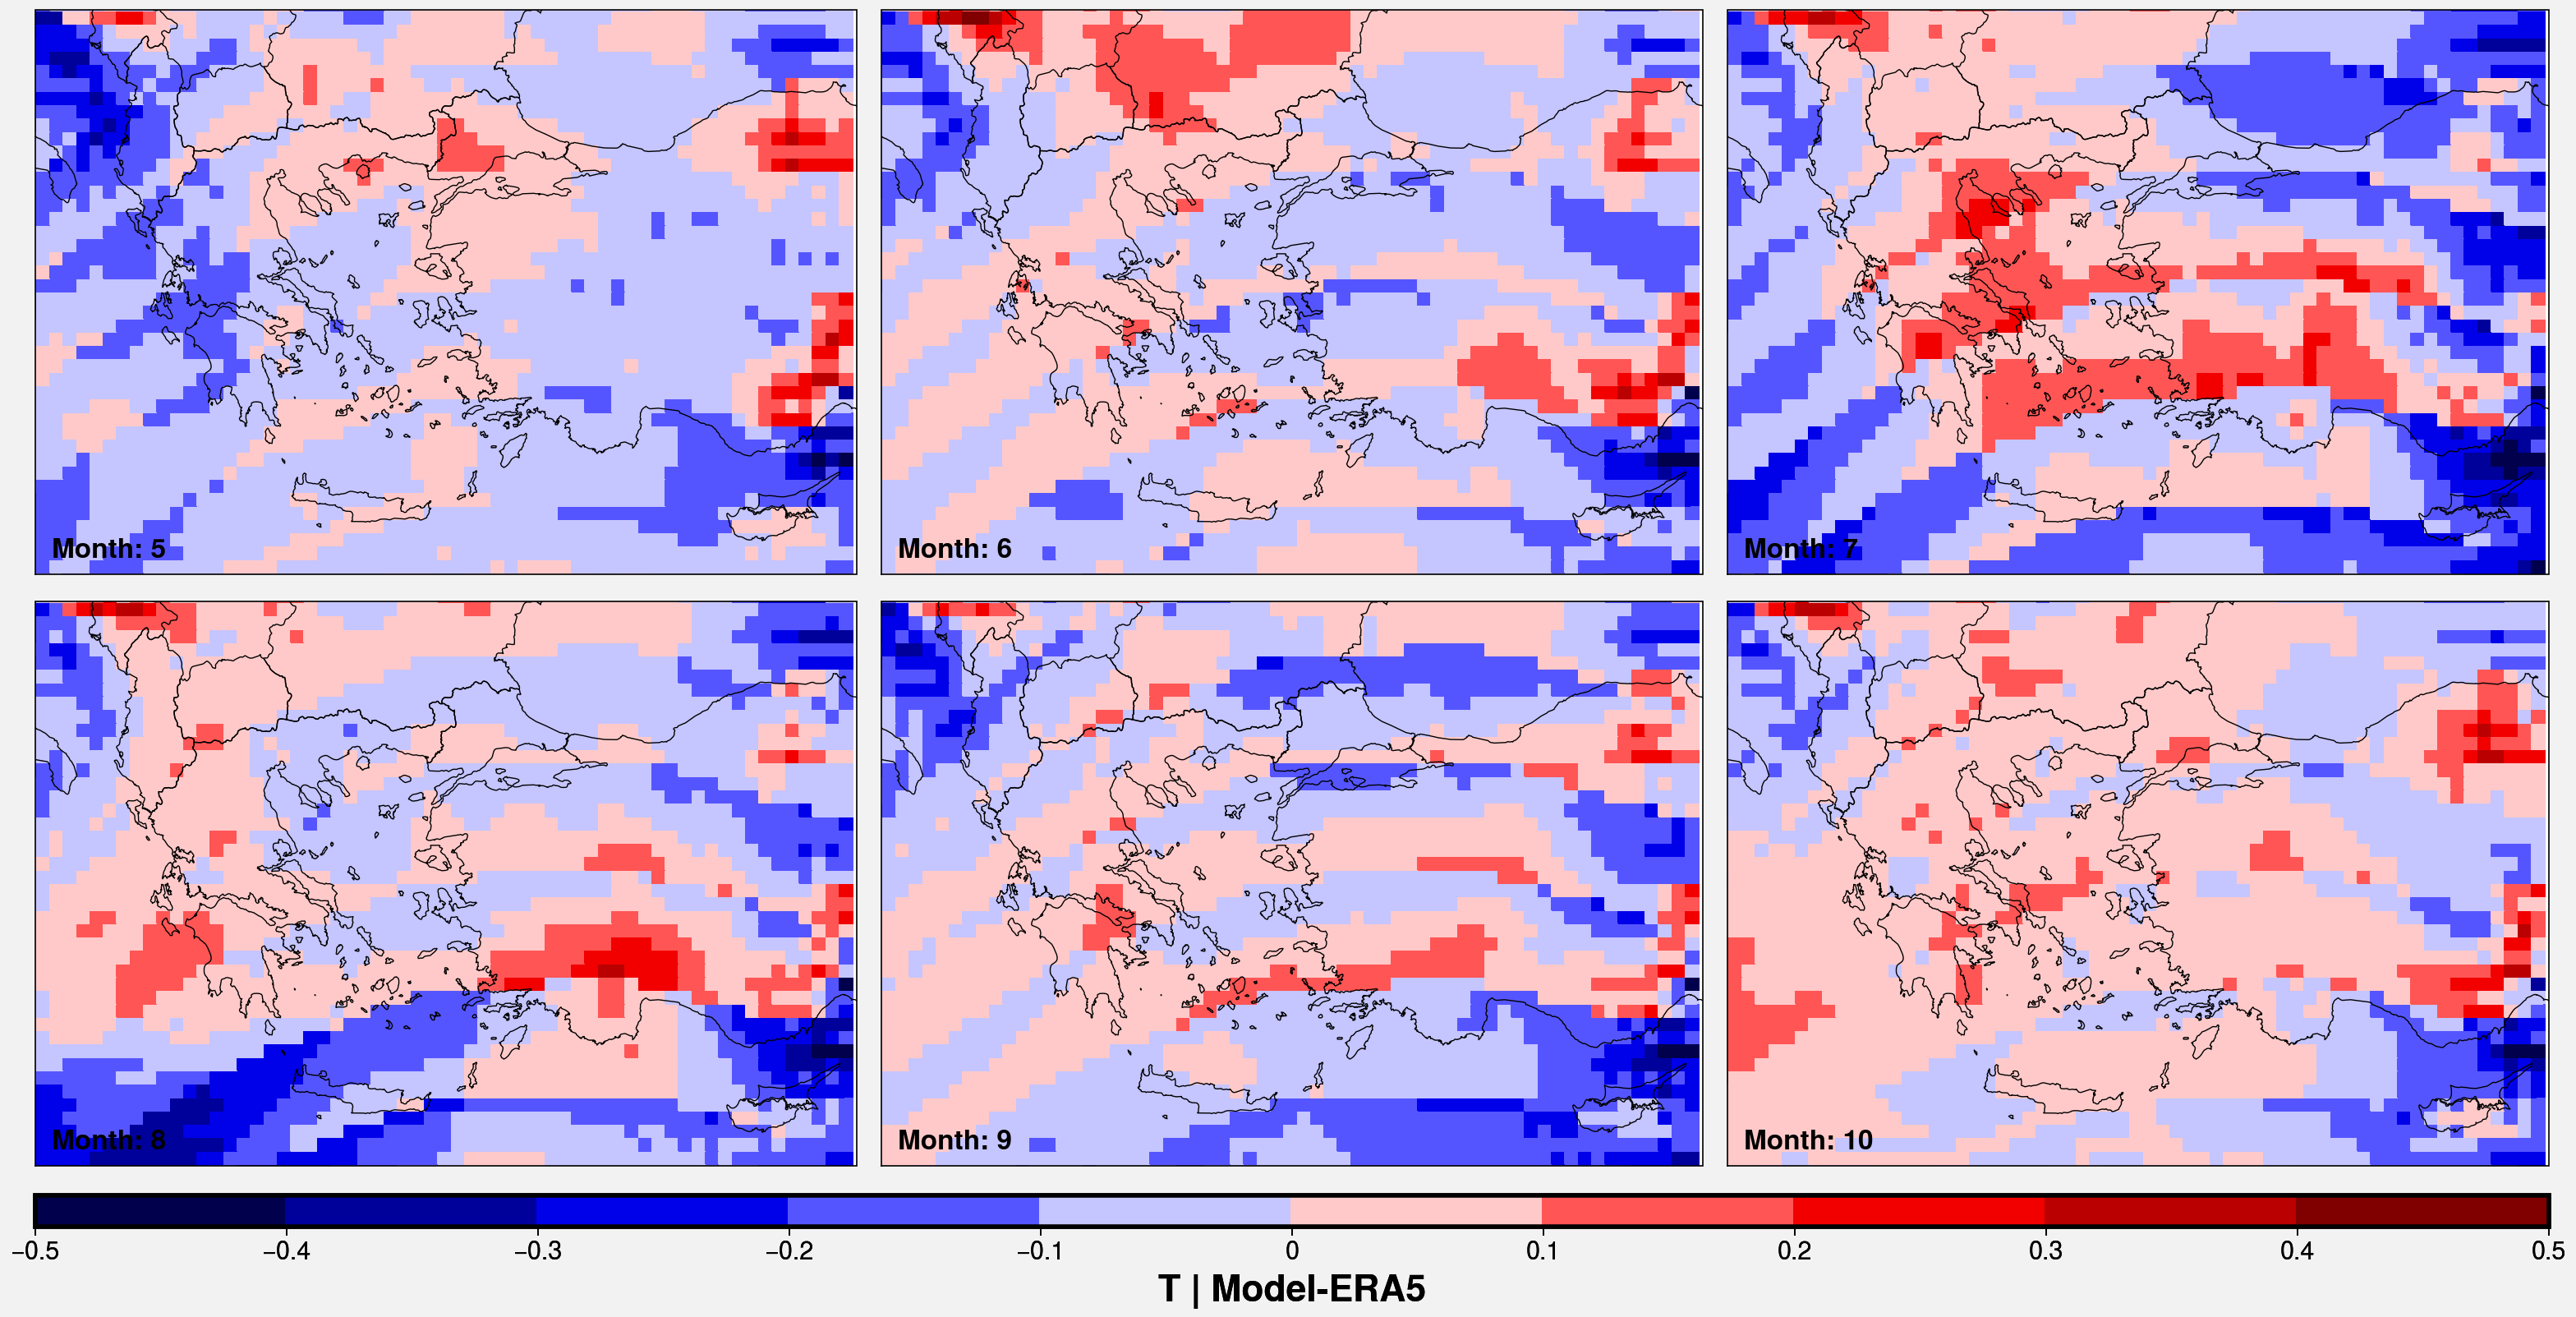

In [51]:
# Parameters to change (plot) -------------------
cmap = plt.get_cmap('seismic')
vmin = -0.5
vmax = 0.5
norm = BoundaryNorm(np.arange(vmin, vmax+0.1, 0.1), ncolors=cmap.N, clip=True)
ticks = np.arange(vmin, vmax + 0.1, 0.1)
# -----------------------

# data
data_df = average_bymonth_difference.sel(month=slice(5,10))

# graphic features
fig_array = [[1,2,3],
            [4,5,6],]
graphic_no = 6
method='Month'
difference_method = 'Model-ERA5'

# projection
crs_data = cartopy.crs.RotatedPole(**crs_parameters)

plot_facet_map(data_df, cmap, vmin, vmax, norm, ticks,
               crs_data, graphic_no, era5_var, model_level,
               plevel, method, difference_method, fig_array)

### 6.2.2 Seasonal Mean Graphic

In [48]:
# seasonal means of each data
season_era5 = calculate_season_means(average_bymonth_reprojected_interp)
season_model = calculate_season_means(average_bymonth_model_interp)

# seasonal difference between data
season_difference = season_era5 - season_model

#### **BELOW, YOU SHOULD CHECK THE PARAMETERS**

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)


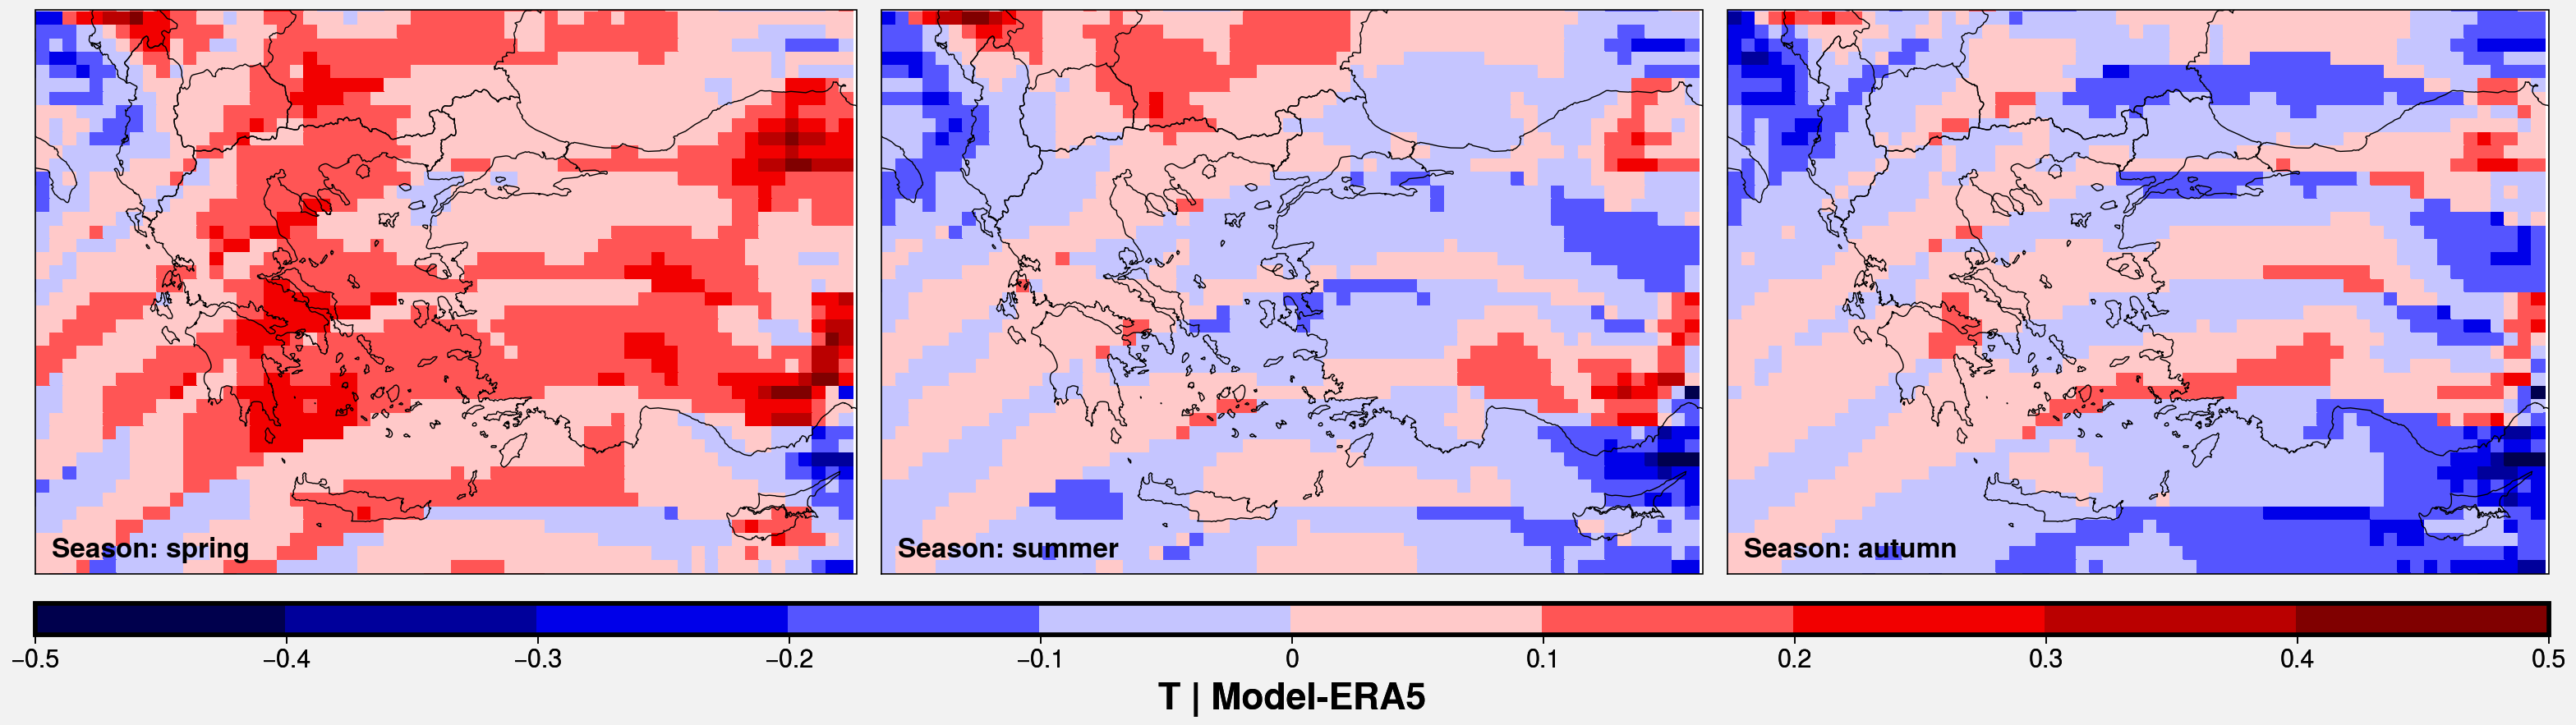

In [50]:
# Parameters to change (plot) -------------------
cmap = plt.get_cmap('seismic')
vmin = -0.5
vmax = 0.5
norm = BoundaryNorm(np.arange(vmin, vmax+0.1, 0.1), ncolors=cmap.N, clip=True)
ticks = np.arange(vmin, vmax + 0.1, 0.1)
# --------------------------

# data
data_df = season_difference

# graphic features
fig_array = [[1,2,3],
            ]
graphic_no = 3
method='Season'
difference_method = 'Model-ERA5'

# projection
crs_data = cartopy.crs.RotatedPole(**crs_parameters)

plot_facet_map(data_df, cmap, vmin, vmax, norm, ticks,
               crs_data, graphic_no, era5_var, model_level,
               plevel, method, difference_method, fig_array)